In [67]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

In [102]:
data = np.genfromtxt('D1_c_5.dat')
m=data.shape[0]
x=np.zeros(m)
y=np.zeros(m)
sigma=np.zeros(m)

for i in range(data.shape[0]):
    x[i]=data[i][0]
    y[i]=data[i][1]
    sigma[i] = data[i][0]

In [97]:
min_sigma=0
max_sigma=100

def log_prior_uni(sigma):
    log_prior = np.ones(len(sigma))
    for i in range(len(sigma)):
        if sigma[i] > min_sigma and sigma[i] < max_sigma:
            log_prior[i] = np.log(1/len(sigma))
        else:
            log_prior[i] = -np.inf
    return log_prior
    
def log_prior_gauss(abar, a): 
    gauss = np.log(1/(np.sqrt(2*np.pi)*abar))+(-a^2/(2*abar^2))
    return gauss

def g(a, x, k):
    g = 0
    for i in range(k):
        g += a(i)*x**i
    return g

def chi_squared(x, y, sigma):
    chi_squared = 0
    for i in range(m):
        chi_squared += ((y[i] - g(a, x[i], k))/sigma[i])**2

def log_likelihood(sigma, chi_squared):
    likelihood = 1
    for j in range(m):
        likelihood += np.log(1/(np.sqrt(2*np.pi)*sigma[j])) - chi_squared /2
    
def log_posterior_uni(sigma):
    return log_prior_uni(sigma) + log_likelihood(theta, X)

def log_posterior_gauss(abar, a, sigma, chi_squared):
    return log_prior_gauss(abar, a) + log_likelihood(sigma, chi_squared)


In [86]:
ndim = 1
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = min_sigma + max_sigma * np.random.rand(nwalkers,ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uni, args=[D])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers


NameError: name 'D' is not defined

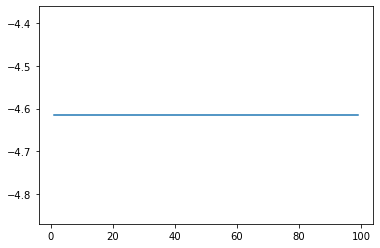

In [101]:
sigma=np.linspace(0,100,101)
plt.plot(sigma, log_prior_uni(sigma));